In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from __future__ import print_function,division
from Pic.maxent_font import tick_font
from Utils.gridCV import gridCV
from Utils.SklearnerHelper import SklearnHelper
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.cross_validation import KFold;
from sklearn import cross_validation, metrics
from sklearn.grid_search import GridSearchCV
from sklearn.feature_selection import SelectFromModel
import xgboost as xgb

/Users/chaoxu/.pyenv/versions/anaconda2-4.3.1/lib/python2.7/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
image_path = "/Users/chaoxu/code/local-spark/Data/image_qiancheng"
ratio = 0.05
model = 'stack'
version = '6v1.0sm'

In [3]:
df = pd.read_csv("/Users/chaoxu/code/local-spark/Data/qiancheng_data/qiancheng_sample_new_merge_{0}/data.csv".format(ratio))

In [4]:
SEED = 1234  # for reproducibility
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
     'warm_start': True,
     #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
}

# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators':500,
    #'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

# AdaBoost parameters
ada_params = {
    'n_estimators': 500,
    'learning_rate' : 0.75
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 500,
     #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

# Support Vector Classifier parameters
svc_params = {
    'kernel' : 'linear',
    'C' : 0.025
}

In [5]:
def merge_ua_proxy(row):
    if row['uaMismatch.value'] >= 1 or row['proxyIP.value'] >=1:
        return 1
    else:
        return 0
df['proxy_ua'] = df.apply(merge_ua_proxy,axis=1)

In [6]:
def resample(data, positiveRatio=0.04):
    positive = data[data["label"] == 1]
    negative = data[data["label"] == 0]
    n = int((1 - positiveRatio) / positiveRatio) * positive.shape[0]
    print(n)
    _negative = negative.sample(n=n)
    df = pd.concat([positive, _negative])
    return df

In [7]:
df[['label']]=df[['label']].fillna(0)

In [8]:
df.loc[(df.label == 1) & (df.os == 'ios')]['maxent_id'].drop_duplicates().count()

159

In [9]:
df.loc[(df.label == 1) & (df.os == 'android')]['maxent_id'].drop_duplicates().count()

303

In [10]:
from datetime import datetime, timedelta
df["timestamp"] = pd.to_datetime(df['timestamp'], unit='ms', utc=True)
df["timestamp"] = pd.DatetimeIndex(df["timestamp"]) + timedelta(hours=8)
df = df.sort_values(by="timestamp")
# df_maxent_id = df['maxent_id'].reset_index(drop=True)
# df_ios_maxent_id = df.loc[df.os == 'ios']['maxent_id'].reset_index(drop=True)
# df_android_maxent_id = df.loc[df.os == 'android']['maxent_id'].reset_index(drop=True)
# df = df.drop(['idcIP.anomaly', 'cracked.anomaly', 'uaMismatch.anomaly','uaMismatch.value','proxyIP.value','proxyIP.anomaly',"timestamp","maxent_id","timestamp",'ipSeg24','ipGeo','event_id','scenario'],axis=1)
df = df.drop(["timestamp","timestamp",'ipSeg24','ipGeo','scenario','uaMismatch.value','proxyIP.value'],axis=1)

df[['label']]=df[['label']].fillna(0)
df[['label']] = df[['label']].astype(int)
df = df.loc[df['event_type'] =='ACT']
df = df.drop(['event_type'],axis=1)

In [11]:
import re
anormaly = re.compile('.*anomaly$')
anormaly_match = np.vectorize(lambda x:bool(anormaly.match(x)))
anormaly_cols = df.columns.values[anormaly_match(df.columns.values)]

value = re.compile('.*value$')
value_match = np.vectorize(lambda x:bool(value.match(x)))
value_cols = df.columns.values[value_match(df.columns.values)]

count = re.compile('.*counts$')
count_match = np.vectorize(lambda x:bool(count.match(x)))
count_cols = df.columns.values[count_match(df.columns.values)]

loan = re.compile('.*loan$')
loan_match = np.vectorize(lambda x:bool(loan.match(x)))
loan_cols = df.columns.values[loan_match(df.columns.values)]

In [12]:
# cols = df.columns
# fig, ax = plt.subplots(figsize=(16,9))
# ax.barh(range(len(cols)),df[cols].isnull().sum()/df.shape[0])
# ax.set_yticks(range(len(cols)))
# ax.set_yticklabels(cols, size=14)
# ax.set_title('features nan percentage',size= 18)
# plt.show()

In [13]:
df.select_dtypes(include=[np.object_]).columns

Index([u'maxent_id', u'event_id', u'os'], dtype='object')

In [14]:
df.select_dtypes(include=[np.bool_]).columns

Index([u'cracked.value', u'idcIP.value'], dtype='object')

In [15]:
from Utils.transfer_event_dev import transfer_event_to_device
df = transfer_event_to_device(df,mode=0)

In [16]:
df.head()

,maxent_id,os,maxentID.6h.anomaly,did.5m.anomaly,maxentID.7d.anomaly,maxentID.5m.anomaly,mcid_counts,cracked.anomaly,imei_loan,imei_counts,...,ipSeg24.7d.value,ipSeg24.5m.anomaly,did.1m.anomaly,maxentID.7d.value,did.1h.value,aid_counts,maxentID.1m.anomaly,did.15m.value,ipGeo.1h.anomaly,ipSeg24.15m.anomaly
0,00092aaaf679fdcb8e2f40d85e49359d,android,1.0,1.0,1.0,1.0,1.0,1,0.0,1.0,...,482.000000,1.0,1.0,1.000000,1.000000,1.0,1.0,1.000000,1.0,1.0
1,000a48fca284e4d00821394b9e0533f2,android,1.0,1.0,1.0,1.0,1.0,1,0.0,1.0,...,4164.000000,1.0,1.0,1.000000,1.000000,1.0,1.0,1.000000,1.0,1.0
2,000b306c678a1183483eacf257d626c8,android,1.0,1.0,1.0,1.0,1.0,1,0.0,1.0,...,18.333333,1.0,1.0,1.333333,1.333333,1.0,1.0,1.333333,2.0,1.0
3,000d9b2ee81db47390feaacb731b0ae7,android,1.0,1.0,1.0,1.0,1.0,1,0.0,1.0,...,1846.500000,1.0,1.0,1.500000,1.000000,1.0,1.0,1.000000,48.0,1.0
4,0013a79d0f84d50a4943b1533463cdad,ios,1.0,1.0,1.0,1.0,1.0,1,0.0,0.0,...,2.000000,1.0,1.0,1.000000,1.000000,0.0,1.0,1.000000,1.0,1.0


In [17]:
# obj_df = df.select_dtypes(include=['object'])
# obj_df.columns

In [18]:
# bool_df = df.select_dtypes(include=['bool'])
# bool_df.columns

In [19]:
def show_missing():
    missing = df.columns[df.isnull().any()].tolist()
    return missing
df[show_missing()].isnull().sum()

Series([], dtype: float64)

整体的label平衡性

In [20]:
df.label.value_counts(normalize=True)

0    0.95
1    0.05
Name: label, dtype: float64

In [21]:
df.columns

Index([u'maxent_id', u'os', u'maxentID.6h.anomaly', u'did.5m.anomaly',
       u'maxentID.7d.anomaly', u'maxentID.5m.anomaly', u'mcid_counts',
       u'cracked.anomaly', u'imei_loan', u'imei_counts', u'ipSeg24.15m.value',
       u'ipGeo.1d.anomaly', u'ipGeo.5m.anomaly', u'cracked.value',
       u'idcIP.value', u'did.15m.anomaly', u'maxentID.1h.value',
       u'maxentID.5m.value', u'ipSeg24.1h.anomaly', u'idfv_counts',
       u'ipGeo.7d.anomaly', u'uaMismatch.anomaly', u'aid_loan',
       u'ipGeo.1d.value', u'did.7d.anomaly', u'maxentID.15m.anomaly',
       u'idfa_loan', u'ipGeo.7d.value', u'ipGeo.15m.value', u'did.5m.value',
       u'label', u'ipSeg24.1h.value', u'maxentID.6h.value',
       u'ipSeg24.5m.value', u'did.6h.anomaly', u'did.7d.value',
       u'maxentID.1d.anomaly', u'ipGeo.15m.anomaly', u'ipGeo.5m.value',
       u'did.1h.anomaly', u'proxy_ua', u'mac_counts', u'did.6h.value',
       u'idfa_counts', u'idcIP.anomaly', u'ipGeo.1m.anomaly',
       u'ipGeo.1h.value', u'ipSeg24.1d.

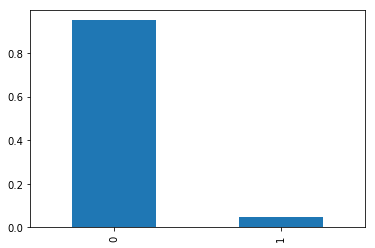

In [22]:
df.label.value_counts(normalize=True).plot(kind='bar')
plt.show()

In [23]:
df['cracked.value'].dtype

dtype('bool')

In [24]:
df_ios = df.loc[df.os == 'ios']

In [25]:
obj_cols = df.select_dtypes(include=[np.object_]).columns.tolist()
# obj_cols.remove('event_id')
print(obj_cols)
bool_cols = df.select_dtypes(include=[np.bool_]).columns.tolist()
print(bool_cols)
encoder_cols = obj_cols + bool_cols
if 'maxent_id' in encoder_cols:
    encoder_cols.remove('maxent_id')
print(encoder_cols)

['maxent_id', 'os']
['cracked.value', 'idcIP.value']
['os', 'cracked.value', 'idcIP.value']


In [26]:
from sklearn.preprocessing import LabelEncoder
class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

In [27]:
df_ios = MultiColumnLabelEncoder(columns = encoder_cols).fit_transform(df_ios)

In [28]:
def show_missing():
    missing = df.columns[df.isnull().any()].tolist()
    return missing
df_ios[show_missing()].isnull().sum()

Series([], dtype: float64)

In [29]:
ios_drop = ['os','aid_loan','imei_loan','mac_loan','imei_counts','mac_counts','aid_counts']
df_ios=df_ios.drop(ios_drop,axis=1)

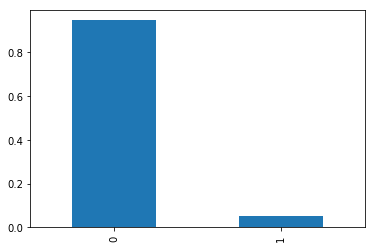

In [30]:
df_ios.label.value_counts(normalize=True).plot(kind='bar')
save_path = image_path + "/ios_label_ratio-{0}-{1}-{2}.png".format(version,ratio,model)
fig = plt.gcf()
fig.savefig(save_path,format='png')
plt.show()

In [31]:
from sklearn.cross_validation import train_test_split
# def splitData(df, ratio):
#     """
#     """
#     positive_maxent_id = df[df["label"] == 1]['maxent_id'].drop_duplicates().reset_index(drop=True)
#     positive_maxent_id_test, positive_maxent_id_train = train_test_split(positive_maxent_id, train_size=ratio)
#     print(positive_maxent_id_train.shape,positive_maxent_id_test.shape)
#     negative_maxent_id = df[df["label"] == 0]['maxent_id'].drop_duplicates().reset_index(drop=True)
#     negative_maxent_id_test, negative_maxent_id_train = train_test_split(negative_maxent_id, train_size=ratio)
#     print(negative_maxent_id_train.shape,negative_maxent_id_test.shape)
#     train_maxent_id = pd.concat([positive_maxent_id_train, negative_maxent_id_train],ignore_index=True)
#     test_maxent_id = pd.concat([positive_maxent_id_test, negative_maxent_id_test],ignore_index=True)
#     df_train = df.loc[df['maxent_id'].isin(train_maxent_id)]
#     df_test = df.loc[df['maxent_id'].isin(test_maxent_id)]
#     return df_train, df_test
# #     df_test = pd.merge(df, test_maxent_id, on='maxent_id', how='inner')
# #     positiveData = df[df["label"] == 1].copy(deep=True)
# #     _positiveTrain, _positiveTest = train_test_split(positiveData, train_size=ratio)
# #     negativeData = df[df["label"] == 0].copy(deep=True)
# #     _negativeTrain, _negativeTest = train_test_split(negativeData, train_size=ratio)
# #     train_set = pd.concat([_positiveTrain, _negativeTrain])
# #     test_set = pd.concat([_positiveTest, _negativeTest])
# #     return train_set, test_set

def splitData(df, ratio):
    """
    """
    positiveData = df[df["label"] == 1].copy(deep=True)
    _positiveTrain, _positiveTest = train_test_split(positiveData, train_size=ratio)
    negativeData = df[df["label"] == 0].copy(deep=True)
    _negativeTrain, _negativeTest = train_test_split(negativeData, train_size=ratio)
    train_set = pd.concat([_positiveTrain, _negativeTrain])
    test_set = pd.concat([_positiveTest, _negativeTest])
    return train_set, test_set


In [32]:
df_ios_train, df_ios_test = splitData(df_ios,0.7)
print(df_ios_train.shape, df_ios_test.shape)
df_ios_maxent_id = df_ios_test['maxent_id'].reset_index(drop=True)
X_ios_train = df_ios_train.ix[:, df_ios_train.columns != 'label'].drop(['maxent_id'],axis=1)
X_ios_test  = df_ios_test.ix[:, df_ios_test.columns != 'label'].drop(['maxent_id'],axis=1)
y_ios_train = df_ios_train.ix[:, df_ios_train.columns == 'label']
y_ios_test  = df_ios_test.ix[:, df_ios_test.columns == 'label']
print("Number transactions ios train dataset: ", X_ios_train.shape[0])
print("Number transactions ios test dataset: ", X_ios_test.shape[0])

(2096, 69) (900, 69)
Number transactions ios train dataset:  2096
Number transactions ios test dataset:  900


第一层机器学习模型

In [44]:
def get_oof(clf, x_train, y_train, x_test):
    ntrain = x_train.shape[0]
    ntest = x_test.shape[0]
    SEED =1234
    NFOLDS = 5  # set folds for out-of-fold prediction
    kf = KFold(ntrain, n_folds=NFOLDS, random_state=SEED)
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf):
#         print(train_index)
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]
        print(y_tr.max(),y_tr.min())

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [37]:
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)

In [35]:
X_ios_train = X_ios_train.values
X_ios_test = X_ios_test.values
y_ios_train=y_ios_train.values
y_ios_test=y_ios_test.values

/Users/chaoxu/code/local-spark/Utils/SklearnerHelper.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.clf.fit(x_train, y_train)
/Users/chaoxu/.pyenv/versions/anaconda2-4.3.1/lib/python2.7/site-packages/sklearn/ensemble/forest.py:304: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn("Warm-start fitting without increasing n_estimators does not "
/Users/chaoxu/.pyenv/versions/anaconda2-4.3.1/lib/python2.7/site-packages/sklearn/utils/validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


ValueError: BinomialDeviance requires 2 classes.

In [41]:
y_ios_train.max()

1

In [46]:
et_oof_train, et_oof_test = get_oof(et, X_ios_train, y_ios_train, X_ios_test) # Extra Trees
rf_oof_train, rf_oof_test = get_oof(rf,X_ios_train, y_ios_train, X_ios_test) # Random Forest
ada_oof_train, ada_oof_test = get_oof(ada, X_ios_train, y_ios_train, X_ios_test) # AdaBoost 
# gb_oof_train, gb_oof_test = get_oof(gb,X_ios_train, y_ios_train, X_ios_test) # Gradient Boost
# svc_oof_train, svc_oof_test = get_oof(svc,X_ios_train, y_ios_train, X_ios_test) # Support Vector Classifier
print("Training is complete")

0 0
1 0
1 0
1 0
1 0
0 0
1 0
1 0
1 0
1 0
0 0
1 0
1 0
1 0
1 0
Training is complete


In [50]:
rf_feature = rf.feature_importances(X_ios_train,y_ios_train)
et_feature = et.feature_importances(X_ios_train, y_ios_train)
ada_feature = ada.feature_importances(X_ios_train, y_ios_train)
# gb_feature = gb.feature_importances(X_ios_train,y_train)

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.0059221   0.00027756  0.00513276  0.00073102  0.05373145  0.
  0.01429921  0.01350605  0.01315082  0.00580337  0.00384553  0.00517904
  0.02457114  0.01759021  0.00920631  0.04336562  0.01673176  0.
  0.01971933  0.00715071  0.00628601  0.03038589  0.01747141  0.02231177
  0.01739003  0.01747672  0.02030825  0.01765555  0.01134043  0.02850081
  0.00461146  0.01203111  0.0150341   0.00562405  0.01443325  0.03071355
  0.04831844  0.          0.00958706  0.01747309  0.01345364  0.01075114
  0.00577286  0.01926197  0.0002069   0.01823455  0.01276687  0.02748983
  0.01452443  0.01700722  0.02736949  0.00629709  0.01097071  0.01960162
  0.01654263  0.01746755  0.00021203  0.02112171  0.01329294  0.00340957
  0.         

In [52]:
base_ios_predictions_train = pd.DataFrame( {'RandomForest': rf_oof_train.ravel(),
     'ExtraTrees': et_oof_train.ravel(),
     'AdaBoost': ada_oof_train.ravel(),
    })
base_ios_predictions_train.head()

,AdaBoost,ExtraTrees,RandomForest
0,0.0,0.0,0.0
1,0.0,0.0,0.0
2,0.0,0.0,0.0
3,0.0,0.0,0.0
4,0.0,0.0,0.0


In [ ]:
# df_ios_test[df_ios_test["label"] == 1]['maxent_id'].drop_duplicates().count()

In [ ]:
# df_ios_test[df_ios_test["label"] == 0]['maxent_id'].drop_duplicates().count()

In [69]:
from __future__ import print_function,division
import itertools
import matplotlib.pylab as plt
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('label 1')
    plt.xlabel('label 0')

In [ ]:
def get_ios_group_label(row):
#     print(row['y_ios_test'].values)
#     if row['y_ios_test'].values[0] == 1:
    return row['y_ios_pred'].max()
#     else:
#         return row['y_ios_pred'].min()

In [ ]:
from sklearn.metrics import confusion_matrix,precision_recall_curve,auc,roc_auc_score,roc_curve,recall_score,precision_score,classification_report
# from sklearn.ensemble import RandomForestClassifier
# params = {'max_features':'auto', 'max_depth': 3, 'min_samples_split': 5, \
#             'class_weight':'balanced','oob_score':True}
# params['n_estimators'] = 2
# params['n_jobs'] = 50
# forest = RandomForestClassifier(**params)
# clf_a = forest.fit(X_ios_train,y_ios_train.values.ravel())
# y_ios_pred = clf_a.predict(x_ios_test)

# df_y_ios_pred = pd.DataFrame(y_ios_pred,columns=['y_ios_pred'])
# df_y_ios_test = pd.DataFrame(y_ios_test.values,columns=['y_ios_test'])
# df_pred = pd.concat([df_ios_maxent_id,df_y_ios_pred,df_y_ios_test],axis=1)
# df_pred_g = df_pred.groupby(['maxent_id','y_ios_test'])

In [ ]:
from sklearn import tree
from IPython.display import Image
import pydotplus
from sklearn import cross_validation, metrics
from sklearn.grid_search import GridSearchCV

In [58]:
tree_base_params = {
    'objective' : 'binary:logistic',
#     'objective' : 'binary:logitraw',
    'nthread':4,
#     'num_class': 2,
#     'scale_pos_weight':scale_ios_ratio,
#     'missing':-6.666,
    'seed':27 
}

In [59]:
params_ios = {}
params_ios.update(tree_base_params)
params_ios

{'nthread': 4, 'objective': 'binary:logistic', 'seed': 27}

In [63]:
# from collections import OrderedDict
# all_test_params = OrderedDict()
cv_params = {
    'pre_dispatch': '2*n_jobs', 
    'refit':True,
    'scoring':'roc_auc',
#     'scoring':'f1_macro',
#     'scoring':'average_precision',
#     'scoring':'accuracy',
#     'scoring':'recall',
    'cv':5,
    'verbose':0
}
all_test_params = {
    'n_estimators':range(10,200,10),
    'max_depth':range(3,10,2),
    'min_child_weight':range(1,6,2),
    'gamma':[i/10.0 for i in range(0,5)],
    'subsample':[i/10.0 for i in range(6,10)],
    'colsample_bytree':[i/10.0 for i in range(6,10)],
    'reg_lambda':[0, 0.001, 0.005, 0.01, 0.05],
    'learning_rate':[i/10.0 for i in range(10,21)],
    'base_score':[i/10.0 for i in range(1,10)],
}

In [61]:
X_ios_stack_train = np.concatenate((et_oof_train, rf_oof_train, ada_oof_train), axis=1)
X_ios_stack_test = np.concatenate((et_oof_test, rf_oof_test, ada_oof_test), axis=1)

In [74]:
from sklearn import tree
from IPython.display import Image
import pydotplus
# X_ios_cols = X_ios_train.columns
X_ios_train_cv = base_ios_predictions_train
y_ios_train_cv = y_ios_train
ios_params,_clf = gridCV(clf=xgb.XGBClassifier,X=X_ios_train_cv,y=y_ios_train_cv,
                         base_params=tree_base_params,all_test_params=all_test_params,cv_parmas=cv_params)

clf_ios = xgb.XGBClassifier(**ios_params)
clf_0 = clf_ios.fit(X_ios_train, y_ios_train)
ios_dot_data = tree.export_graphviz(clf_0, out_file=None, feature_names=X_ios_train.columns,class_names=['label 0','label 1'],\
                               filled=True, rounded=True, special_characters=True, leaves_parallel=False)
graph = pydotplus.graph_from_dot_data(ios_dot_data)
Image(graph.create_png())

find best params of {'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190]}


IndexError: too many indices for array

In [ ]:
# save_path = image_path + "/ios_tree-{0}-{1}-{2}.png".format(version,ratio,model)
# graph.write_png(save_path)

In [ ]:
# # y_ios_pred = clf_0.predict(x_ios_test)

# df_y_ios_pred = pd.DataFrame(y_ios_pred,columns=['y_ios_pred'])
# df_y_ios_test = pd.DataFrame(y_ios_test.values,columns=['y_ios_test'])
# df_pred = pd.concat([df_ios_maxent_id,df_y_ios_pred,df_y_ios_test],axis=1)
# df_pred_g = df_pred.groupby(['maxent_id','y_ios_test'])

# df_pred_g_apply=df_pred_g.apply(lambda x:get_ios_group_label(x)).reset_index(name='y_ios_pred_max')

# y_ios_test_m = df_pred_g_apply['y_ios_test']
# y_ios_pred_m = df_pred_g_apply['y_ios_pred_max']

# print(X_ios_test.size)
# print(y_ios_test_m.size)
# # Compute confusion matrix
# cnf_matrix = confusion_matrix(y_ios_test_m,y_ios_pred_m)
# np.set_printoptions(precision=2)
# np.set_printoptions(precision=2)
# recall = cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1])
# precision = cnf_matrix[1,1]/(cnf_matrix[0,1]+cnf_matrix[1,1])
# f2 = 0.2*(4/recall + 1/precision)
# print("Recall metric in the testing dataset: ", recall)
# print("Precision metric in the testting dataset:", precision)
# print("f2 metric in the testting dataset:", f2)
# # Plot non-normalized confusion matrix
# class_names = [0,1]
# plt.figure()
# plot_confusion_matrix(cnf_matrix
#                       , classes=class_names
#                       , title='Confusion matrix')

# print(classification_report(y_ios_test_m, y_ios_pred_m, target_names=['0','1']))
# save_path = image_path + "/tree_ios_conf-{0}-{1}-{2}.png".format(version,ratio,model)
# fig = plt.gcf()
# fig.savefig(save_path,format='png')
# plt.show()

/Users/chaoxu/.pyenv/versions/anaconda2-4.3.1/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in long_scalars
/Users/chaoxu/.pyenv/versions/anaconda2-4.3.1/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in double_scalars


Recall metric in the testing dataset:  0.0
Precision metric in the testting dataset: nan
f2 metric in the testting dataset: nan
             precision    recall  f1-score   support

          0       0.95      1.00      0.97       852
          1       0.00      0.00      0.00        48

avg / total       0.90      0.95      0.92       900



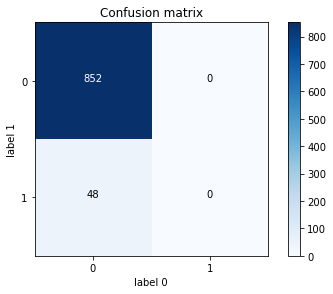

In [72]:
from sklearn.metrics import confusion_matrix,precision_recall_curve,auc,roc_auc_score,roc_curve,recall_score,precision_score,classification_report
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_ios_test,y_ios_pred)
np.set_printoptions(precision=2)
np.set_printoptions(precision=2)
recall = cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1])
precision = cnf_matrix[1,1]/(cnf_matrix[0,1]+cnf_matrix[1,1])
f2 = 0.2*(4/recall + 1/precision)
print("Recall metric in the testing dataset: ", recall)
print("Precision metric in the testting dataset:", precision)
print("f2 metric in the testting dataset:", f2)
# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')

print(classification_report(y_ios_test, y_ios_pred, target_names=['0','1']))
save_path = image_path + "/tree_ios_conf_event-{0}-{1}-{2}.png".format(version,ratio,model)
fig = plt.gcf()
fig.savefig(save_path,format='png')
plt.show()

In [73]:
from mlxtend.plotting import plot_learning_curves
y_ios_train_f = y_ios_train.label.astype(float)
y_ios_test_f = y_ios_test.label.astype(float)
fig,ax= plt.subplots(figsize=(10,10))
ax.grid(b=False)
plot_learning_curves(X_ios_train, y_ios_train_f, X_ios_test, y_ios_test_f, clf_0, print_model=False,style='ggplot')

save_path = image_path + "/ios_learning_perf-{0}-{1}-{2}.png".format(version,ratio,model)
fig = plt.gcf()
fig.savefig(save_path,format='png')
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'label'

In [ ]:
df_feature_ios = pd.DataFrame(X_ios_train.columns.values,columns=['column'])
df_importance = pd.DataFrame(clf_0.feature_importances_,columns=['feature importances'])
df_ios_fim = pd.concat([df_feature_ios,df_importance],axis=1)
fig,ax= plt.subplots(figsize=(20,10))
df_ios_fim=df_ios_fim.sort(['feature importances'],ascending=False)
for x, y in enumerate(df_ios_fim['feature importances'].values):
    ax.bar(x, y)
x_labels = df_ios_fim['column'].values
ax.set_xticks(range(len(x_labels)))
ax.set_xticklabels(x_labels)
tick_font(ax,font_size="small",rotation=90)

save_path = image_path + "/ios_feature_importance-{0}-{1}-{2}.png".format(version,ratio,model)
fig = plt.gcf()
fig.savefig(save_path,format='png')
plt.show()

In [ ]:
df_android = df.loc[df.os == 'android']
df_android = MultiColumnLabelEncoder(columns = encoder_cols).fit_transform(df_android)

In [ ]:
df_android.label.value_counts(normalize=True).plot(kind='bar')

save_path = image_path + "/android_label_ratio-{0}-{1}-{2}.png".format(version,ratio,model)
fig = plt.gcf()
fig.savefig(save_path,format='png')
plt.show()

In [ ]:
df_android[show_missing()].isnull().sum()

In [ ]:
android_drop = ['os','idfa_loan','idfa_counts', u'idfv_counts','imei_loan']
df_android =df_android.drop(android_drop,axis=1)
# df_android = df_android.sample(frac=1).reset_index(drop=True)

In [ ]:
df_android_train, df_android_test = splitData(df_android,0.7)
df_android_maxent_id = df_android_test['maxent_id'].reset_index(drop=True)
X_android_train = df_android_train.ix[:, df_android_train.columns != 'label'].drop(['maxent_id'],axis=1)
X_android_test  = df_android_test.ix[:, df_android_test.columns != 'label'].drop(['maxent_id'],axis=1)
y_android_train = df_android_train.ix[:, df_android_train.columns == 'label']
y_android_test  = df_android_test.ix[:, df_android_test.columns == 'label']
print("Number transactions android train dataset: ", X_android_train.shape[0])
print("Number transactions android test dataset: ", X_android_test.shape[0])
print("Total number of android transactions: ", X_android_train.size)

In [ ]:
df_android_test[df_android_test["label"] == 1]['maxent_id'].drop_duplicates().count()

In [ ]:
df_android_test[df_android_test["label"] == 0]['maxent_id'].drop_duplicates().count()

In [ ]:
params_android = {}
params_android.update(tree_base_params)
params_android

In [ ]:
X_android_cols = X_android_train.columns
X_android_train_cv = X_android_train[X_android_cols]
y_android_train_cv = y_android_train['label']
android_params,_clf = gridCV(clf=tree.DecisionTreeClassifier,X=X_android_train_cv,y=y_android_train_cv,
                             base_params=tree_base_params,all_test_params=all_test_params,cv_parmas=cv_params)

clf_android = tree.DecisionTreeClassifier(**android_params)
clf_1 = clf_android.fit(X_android_train, y_android_train)

dot_data_android = tree.export_graphviz(clf_1, out_file=None, feature_names=X_android_train.columns,class_names=['label 0','label 1'],\
                               filled=True, rounded=True, special_characters=True, leaves_parallel=False)
graph = pydotplus.graph_from_dot_data(dot_data_android)
# graph.write_pdf("Odec_tree.pdf")
Image(graph.create_png())

In [ ]:
save_path = image_path + "/android_tree-{0}-{1}-{2}.png".format(version,ratio,model)
print(save_path)
graph.write_png(save_path)

In [ ]:
def get_android_group_label(row):
#     if row['y_android_test'].values[0] == 1:
    return row['y_android_pred'].max()
#     else:
#         return row['y_android_pred'].min()

In [ ]:
y_android_pred = clf_1.predict(X_android_test)

In [ ]:
df_y_android_pred = pd.DataFrame(y_android_pred,columns=['y_android_pred'])
df_y_android_test = pd.DataFrame(y_android_test.values,columns=['y_android_test'])
df_android_pred = pd.concat([df_android_maxent_id,df_y_android_pred,df_y_android_test],axis=1)
df_android_pred_g = df_android_pred.groupby(['maxent_id','y_android_test'])

df_android_pred_g_apply=df_android_pred_g.apply(lambda x:get_android_group_label(x)).reset_index(name='y_android_pred_max')

y_android_test_m = df_android_pred_g_apply['y_android_test']
y_android_pred_m = df_android_pred_g_apply['y_android_pred_max']
print(X_android_test.shape)
print(y_android_test_m.shape)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_android_test_m,y_android_pred_m)
np.set_printoptions(precision=2)
np.set_printoptions(precision=2)
recall = cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1])
precision = cnf_matrix[1,1]/(cnf_matrix[0,1]+cnf_matrix[1,1])
f2 = 0.2*(4/recall + 1/precision)
print("Recall metric in the testing dataset: ", recall)
print("Precision metric in the testting dataset:", precision)
print("f2 metric in the testting dataset:", f2)
# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')

print(classification_report(y_android_test_m, y_android_pred_m, target_names=['0','1']))
save_path = image_path + "/tree_android_conf-{0}-{1}-{2}.png".format(version,ratio,model)
fig = plt.gcf()
fig.savefig(save_path,format='png')
plt.show()

In [ ]:

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_android_test,y_android_pred)
np.set_printoptions(precision=2)
np.set_printoptions(precision=2)
recall = cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1])
precision = cnf_matrix[1,1]/(cnf_matrix[0,1]+cnf_matrix[1,1])
f2 = 0.2*(4/recall + 1/precision)
print("Recall metric in the testing dataset: ", recall)
print("Precision metric in the testting dataset:", precision)
print("f2 metric in the testting dataset:", f2)
# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')

print(classification_report(y_android_test, y_android_pred, target_names=['0','1']))
save_path = image_path + "/tree_android_event_conf-{0}-{1}-{2}.png".format(version,ratio,model)
fig = plt.gcf()
fig.savefig(save_path,format='png')
plt.show()

In [ ]:
from mlxtend.plotting import plot_learning_curves
y_android_train_f = y_android_train.label.astype(float)
y_android_test_f = y_android_test.label.astype(float)
fig,ax= plt.subplots(figsize=(10,10))
ax.grid(b=False)
plot_learning_curves(X_android_train, y_android_train_f, X_android_test, y_android_test_f, clf_1, print_model=False,style='ggplot')

save_path = image_path + "/android_learning_perf-{0}-{1}-{2}.png".format(version,ratio,model)
fig = plt.gcf()
fig.savefig(save_path,format='png')
plt.show()

In [ ]:
df_feature_android = pd.DataFrame(X_android_train.columns.values,columns=['column'])
df_android_importance = pd.DataFrame(clf_1.feature_importances_,columns=['feature importances'])
df_android_fim = pd.concat([df_feature_android,df_android_importance],axis=1)
fig,ax= plt.subplots(figsize=(20,10))
df_android_fim=df_android_fim.sort(['feature importances'],ascending=False)
for x, y in enumerate(df_android_fim['feature importances'].values):
    ax.bar(x, y)
x_labels = df_android_fim['column'].values
ax.set_xticks(range(len(x_labels)))
ax.set_xticklabels(x_labels)
tick_font(ax,font_size="small",rotation=90)
save_path = image_path + "/android_feature_importance-{0}-{1}-{2}.png".format(version,ratio,model)
fig = plt.gcf()
fig.savefig(save_path,format='png')
plt.show()